# This note book uses landsat COG datasets

The landsat 8 and 9 data is used for Bengaluru city from Microsoft azure. Here the COG file is read the aio is searched,
some of the indexes are also found and the surface temperature is also visualized.

In [ ]:
# Here is the link to the cloud storage and all the information about the data.
# https://planetarycomputer.microsoft.com/dataset/group/landsat

In [ ]:
#pip install odc.stac

# The important libraries are imported

In [1]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

# The url is used to access the data required, here it is landsat-c2-l2 data.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Here our aio is Bengaluru, Karnataka with the time frame of 1st Jan 2022 to 12th Dec 2022.

In [3]:
bbox_of_interest = [77.23453545991674, 12.721173588874311, 77.9642599519662, 13.18629077637431]
time_of_interest = "2022-01-01/2022-12-31"

In [5]:
#pip install satsearch

In [6]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)


items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 19 Items


In [7]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC09_L2SP_144051_20220225_02_T1 from 2022-02-25 with 0.01% cloud cover


# The following will show the available assets/ bands of the cog.

In [8]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

# The RGB image is shown for Bengaluru, along with the band information.

In [10]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data


<xarray.Dataset>
Dimensions:      (y: 1744, x: 2659)
Coordinates:
  * y            (y) float64 1.46e+06 1.46e+06 1.46e+06 ... 1.407e+06 1.407e+06
  * x            (x) float64 7.422e+05 7.422e+05 ... 8.219e+05 8.219e+05
    spatial_ref  int32 32643
    time         datetime64[ns] 2022-02-25T05:10:57.286459
Data variables:
    nir08        (y, x) uint16 15182 15717 17528 17783 ... 14594 14268 14459
    red          (y, x) uint16 11291 11261 12717 13218 ... 9050 9144 9047 9041
    green        (y, x) uint16 10045 10177 11013 11318 ... 9106 9025 8947 8957
    blue         (y, x) uint16 8775 8951 9489 9694 9664 ... 8166 8121 8117 8119
    qa_pixel     (y, x) uint16 21824 21824 21824 21824 ... 21824 21824 21824
    lwir11       (y, x) uint16 47966 47975 47999 47885 ... 46050 46025 46031

In [13]:
#print(bands_of_interest)

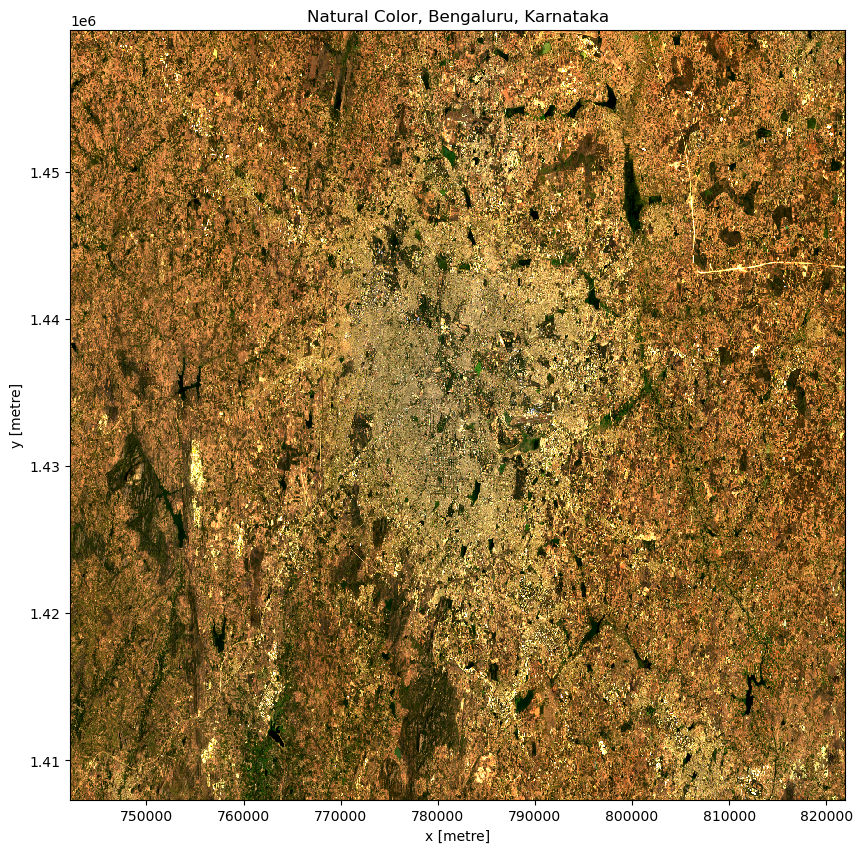

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Bengaluru, Karnataka");

# The NDVI index is found.

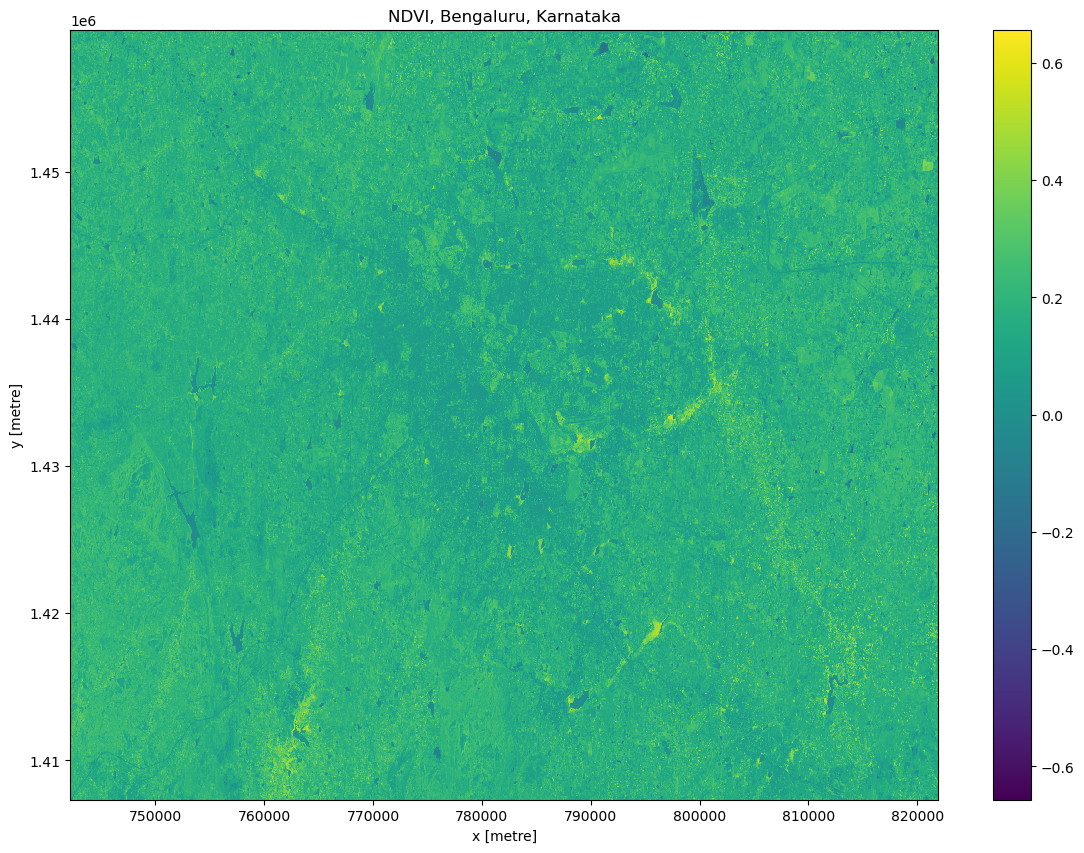

In [15]:
red = data["red"].astype("float")
nir = data["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(14, 10))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_title("NDVI, Bengaluru, Karnataka");

# The bands can be merged and the array is printed.

In [16]:
red = data["red"].astype("float")
green = data["green"].astype("float")
blue = data["blue"].astype("float")
bands = red + green + blue
print(bands)

<xarray.DataArray (y: 1744, x: 2659)>
array([[30111., 30389., 33219., ..., 30893., 27538., 27365.],
       [26717., 28679., 32539., ..., 33579., 31933., 30440.],
       [27503., 28719., 32091., ..., 29924., 33299., 33355.],
       ...,
       [30913., 30468., 30304., ..., 28296., 27707., 27323.],
       [29254., 29623., 30386., ..., 26510., 26429., 26520.],
       [29458., 30801., 31870., ..., 26290., 26111., 26117.]])
Coordinates:
  * y            (y) float64 1.46e+06 1.46e+06 1.46e+06 ... 1.407e+06 1.407e+06
  * x            (x) float64 7.422e+05 7.422e+05 ... 8.219e+05 8.219e+05
    spatial_ref  int32 32643
    time         datetime64[ns] 2022-02-25T05:10:57.286459


# The data can be found in different platform.

In [21]:
catalog.get_collection("landsat-c2-l2").summaries.to_dict()["platform"]

['landsat-4', 'landsat-5', 'landsat-7', 'landsat-8', 'landsat-9']

In [22]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 10},
        "platform": {"in": ["landsat-8", "landsat-9"]},
    },
)
items = search.get_all_items()
# The above query searches for platform only in landsat 8 and 9 just in case one wants to avoid the scanline error in landsat 7.

# Rescaling the B10 temperature 

In [29]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

In [34]:
temperature = data["lwir11"].astype(float)
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:4, :4]

<xarray.DataArray 'lwir11' (y: 4, x: 4)>
array([[312.94874732, 312.9795095 , 313.06154198, 312.6718877 ],
       [313.17775466, 313.2016808 , 313.22902496, 312.71632196],
       [313.24611506, 313.27687724, 313.17091862, 312.47022452],
       [313.45461428, 313.28371328, 312.94874732, 312.1250045 ]])
Coordinates:
  * y            (y) float64 1.46e+06 1.46e+06 1.46e+06 1.46e+06
  * x            (x) float64 7.422e+05 7.422e+05 7.422e+05 7.423e+05
    spatial_ref  int32 32643
    time         datetime64[ns] 2022-02-25T05:10:57.286459
Attributes:
    nodata:   0

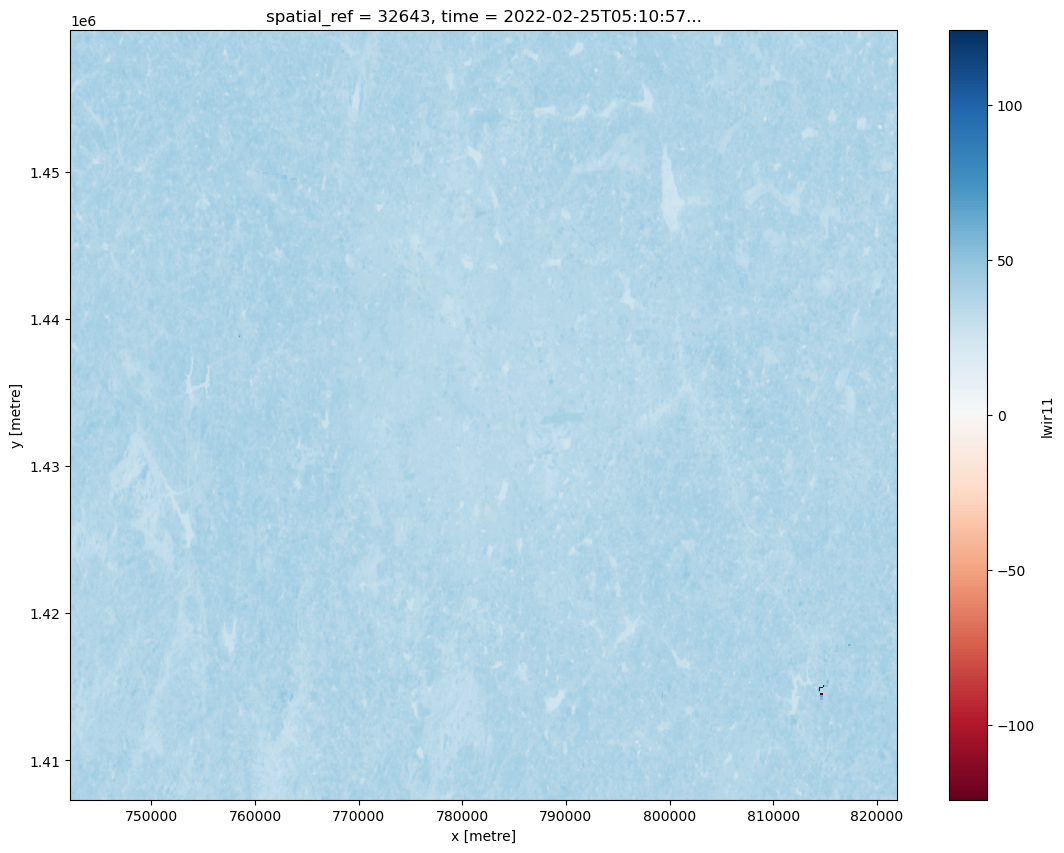

In [41]:
celsius = temperature - 273.15
celsius.plot(cmap="RdBu", size=10);